# Imports

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

# Loading and Preparing the data

The data is from Kaggle in csv format.

In [2]:
train_data = pandas.read_csv('./data/train.csv')
test_data = pandas.read_csv('./data/test.csv')

Divide the training daa into validation and training set.

In [3]:
val_data = train_data[:int(len(train_data)/10)]
train_data = train_data[int(len(train_data)/10):]

Get the training labels and prepare the data. IN the end we also reshape the data

In [4]:
train_y = to_categorical(train_data["label"])
train_x = train_data.loc[:, train_data.columns != "label"]
train_x /= 256

val_y = to_categorical(val_data["label"])
val_x = val_data.loc[:, val_data.columns != "label"]
val_x /= 256

train_x = train_x.values.reshape(-1, 28, 28, 1)
val_x = val_x.values.reshape(-1, 28, 28, 1)

# Define the model

In [5]:
model = Sequential()
model.add(Conv2D(256, (3,3), activation='relu', input_shape=(28,28, 1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(96, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.15))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='sigmoid'))

In [6]:
model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 256)       2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       295040    
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 11, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 96)          110688    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          55360     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0

# Augment the data

In [8]:
datagen = ImageDataGenerator(
    rotation_range=5,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15
)

datagen.fit(train_x)

# Define the callback and train

In [9]:
callback = EarlyStopping(monitor='accuracy', patience=8, restore_best_weights=True)

In [10]:
history = model.fit(datagen.flow(train_x, train_y, batch_size=32), epochs=80, validation_data=(val_x, val_y), callbacks=[callback])

Epoch 1/80
1182/1182 [==============================] - 13s 6ms/step - loss: 1.2642 - accuracy: 0.5631 - val_loss: 0.1335 - val_accuracy: 0.9631
Epoch 2/80
1182/1182 [==============================] - 7s 6ms/step - loss: 0.3091 - accuracy: 0.9045 - val_loss: 0.1341 - val_accuracy: 0.9605
Epoch 3/80
1182/1182 [==============================] - 7s 6ms/step - loss: 0.1984 - accuracy: 0.9375 - val_loss: 0.1217 - val_accuracy: 0.9664
Epoch 4/80
1182/1182 [==============================] - 7s 6ms/step - loss: 0.1494 - accuracy: 0.9569 - val_loss: 0.0654 - val_accuracy: 0.9826
Epoch 5/80
1182/1182 [==============================] - 7s 6ms/step - loss: 0.1259 - accuracy: 0.9631 - val_loss: 0.0748 - val_accuracy: 0.9781
Epoch 6/80
1182/1182 [==============================] - 7s 6ms/step - loss: 0.1010 - accuracy: 0.9700 - val_loss: 0.0569 - val_accuracy: 0.9829
Epoch 7/80
1182/1182 [==============================] - 7s 6ms/step - loss: 0.0960 - accuracy: 0.9708 - val_loss: 0.0369 - val_accuracy

# Visualize your results

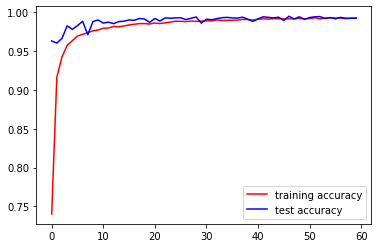

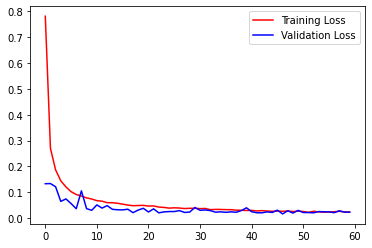

In [11]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='training accuracy')
plt.plot(epochs, val_acc, 'b', label='test accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.legend()
plt.show()

# Create the submission

In [12]:
test_x = test_data.values.reshape(-1, 28, 28, 1)
test_x/=256

In [13]:
y_pred = model.predict(test_x)

In [14]:
print(y_pred)

[[0.         1.         1.         ... 1.         0.         0.        ]
 [1.         0.         1.         ... 0.         0.         0.9996934 ]
 [1.         0.         1.         ... 1.         0.         1.        ]
 ...
 [0.         0.19715671 1.         ... 0.         1.         0.        ]
 [0.         0.         1.         ... 1.         0.         1.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]]


In [15]:
y_pred = numpy.argmax(y_pred, axis=1)

In [16]:
print(y_pred)

[1 0 0 ... 2 2 2]


In [17]:
y_pred = pandas.Series(y_pred,name='Label')

In [18]:
submission = pandas.concat([pandas.Series(range(1, 28001), name='ImageId'), y_pred], axis=1)
submission.to_csv('submission.csv', index=False)